![Clase aprendizaje no supervisado](https://raw.githubusercontent.com/MECA4605-Aprendizaje-no-supervisado/S8_analisis_geografico_II/main/figs/taller-meca-aprendizaje%20no%20supervisado_banner%201169%20x%20200%20px%20-05.png)

# Modelo de Mezclas Gaussianas. Fundamentos teóricos.

Este *cuaderno* trata sobre el Modelo de Mezclas Gaussianas. Los objetivos del *cuaderno* son: que usted aprenda los fundamentos teóricos del modelo de mezclas gaussianas, que sea capaz de reconocer sus características, funcionamiento, de cómo implementarlo y utilizarlo para el análisis  de puntos calientes geográficos.

**NO** es necesario editar el archivo o hacer una entrega. Sin embargo, los ejemplos contienen celdas con código ejecutable (`en gris`), que podrá modificar  libremente. Esta puede ser una buena forma de aprender nuevas funcionalidades del *cuaderno*, o experimentar variaciones en los códigos de ejemplo.

## Introducción


El Modelo de Mezclas Gaussianas o *Gaussian Mixture Model (GMM)* en inglés, es un modelo probabilístico para la estimación de densidad. Este modelo postula que la distribución subyacente es un a mezcla (combinación) de distribuciones gaussianas y al asumir esto, el problema de estimación de densidad se resume a estimar los parámetros de las distribuciones subyacentes y los ponderadores. Por ejemplo, si el modelo subyacente mezcla dos distribuciones gaussianas, es decir tiene dos componentes, tenemos entonces que encontrar la media, la matriz de covarianza de cada una y el ponderador.

Este tipo de modelo se utiliza también para el análisis de clústeres. Es más puede ser entendido como una generalización de K-medias, donde en lugar de asignar cada observación a un único clúster, obtenemos una distribución de probabilidad de pertenencia a cada grupo. Una de las ventajas de este modelo es que al tener la distribución de probabilidad, aquellas observaciones con baja densidad pueden ser clasificados como datos atípicos u *outliers*.



## Modelo de mezclas gaussianas

Formalmente, en los modelos de mezclas gaussianas describimos la función de densidad como:

\begin{align}
f( x| \theta) &= \sum_{k=1}^K \pi_k N( x|  \mu_k,  \Sigma_k)\\
\pi_k &\geq 0 \\
\sum_{k=1}^K\pi_k &= 1
\end{align}


Donde $\theta=\{ \mu_k,  \Sigma_k, \pi_k\ \}$ con $k=1,...,K$ son los parámetros de la densidad. $N( x|  \mu_k,  \Sigma_k)$ denota la k-ésima distribución normal (gaussiana) con media $\mu_k$ y matriz de covarianza $\Sigma_k$. Y $\pi_k$ son los ponderadores, que no deben ser negativos y deben sumar uno.

Notemos que estos tipos de modelos son más flexibles que aquellos que asumen una única distribución base, puesto que permiten descubrir distribuciones subyacentes multimodales, por ejemplo, pueden describir datos con múltiples puntos calientes o “clústeres”. Estos modelos paramétricos tienen ventaja versus los no paramétricos que estudiamos en el *cuaderno: Estimación de Densidades para el Análisis de Puntos Calientes. Fundamentos Teóricos.* ya que suelen ser más veloces y más eficientes cuando la distribución subyacente está correctamente especificada.

Ilustremos cómo luce una MMG descrita por la siguiente ecuación:

\begin{align}
f( x| \theta)=\color{blue}{\frac{1}{2}*N( x|  1,  2.5)} + \color{orange}{\frac{1}{3}*N( x|  10,  4)} + \color{green}{\frac{1}{3}*N( x|  -12,  5)}
\end{align}


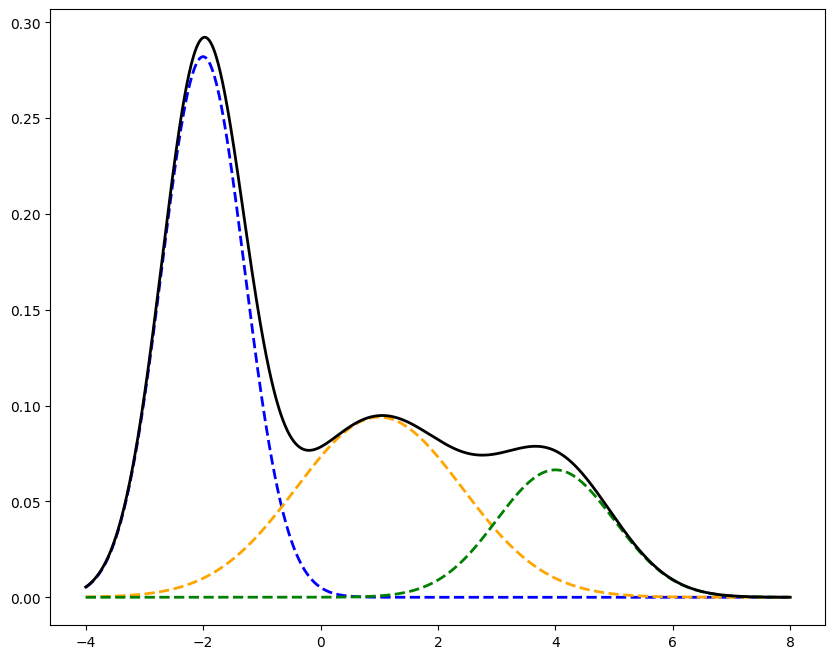

In [1]:
#Cargamos las librerías a utilizar
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

#Creamos el soporte
x = np.linspace(-4, 8, 1000)[:, np.newaxis]

#Creamos los 3 Componentes (notar que scipy.stats.norm requiere como insumo el desvío estándar)
Componente1 = (1 / 2) *scipy.stats.norm(-2, np.sqrt(0.5)).pdf(x[:, 0])
Componente2 = (1 / 3) *scipy.stats.norm(1, np.sqrt(2)).pdf(x[:, 0])
Componente3 = (1 / 6) * scipy.stats.norm(4, 1).pdf(x[:, 0])

#Definimos la MMG
mmg = Componente1 + Componente2 + Componente3


#Graficamos la densidad
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(x, Componente1, '--', linewidth=2,color="blue")
plt.plot(x, Componente2, '--', linewidth=2,color="orange")
plt.plot(x, Componente3, '--', linewidth=2,color="green")
plt.plot(x, mmg, '-', linewidth=2,color="black")
plt.show()

La distribución resultante de mezclas gaussianas (en negro) es entonces una combinación convexa de las 3 distribuciones componentes (azul, naranja, y verde). Notemos además que en el *cuaderno: Estimación de Densidades para el Análisis de Puntos Calientes. Fundamentos Teóricos* utilizamos una MMG como modelo verdadero subyacente para ilustrar la implementación de KDE y de los parámetros que la gobiernan.

### Aprendizaje de parámetros

Dado los parámetros $\theta=\{ \mu_k,  \Sigma_k, \pi_k\ \}$  de la densidad, es necesario estimarlos. Para ello utilizaremos la estimación de máxima verosimilitud, es decir, los parámetros son los que resuelven el siguiente problema:

\begin{align}
\theta^* = \underset{\theta}{arg\,max}=\Pi_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}( x|  \mu_k,  \Sigma_k)
\end{align}

Para este ejemplo imaginemos que tenemos las siguientes 7 observaciones $X=\{-3,-2.5,-1,0,2,4,5\}$ representadas en negro en la figura de abajo y queremos encontrar una MMG con 3 componentes que mejor ajusten a estos datos. Para iniciar el proceso asumimos que:

\begin{align}
f( x| \theta)=\color{blue}{\frac{1}{3}*N( x|  -4,  1)} + \color{orange}{\frac{1}{3}*N( x|  0,  0.2)} + \color{green}{\frac{1}{3}*N( x|  8,  3)}
\end{align}

Representada junto a los componentes la figura de abajo:

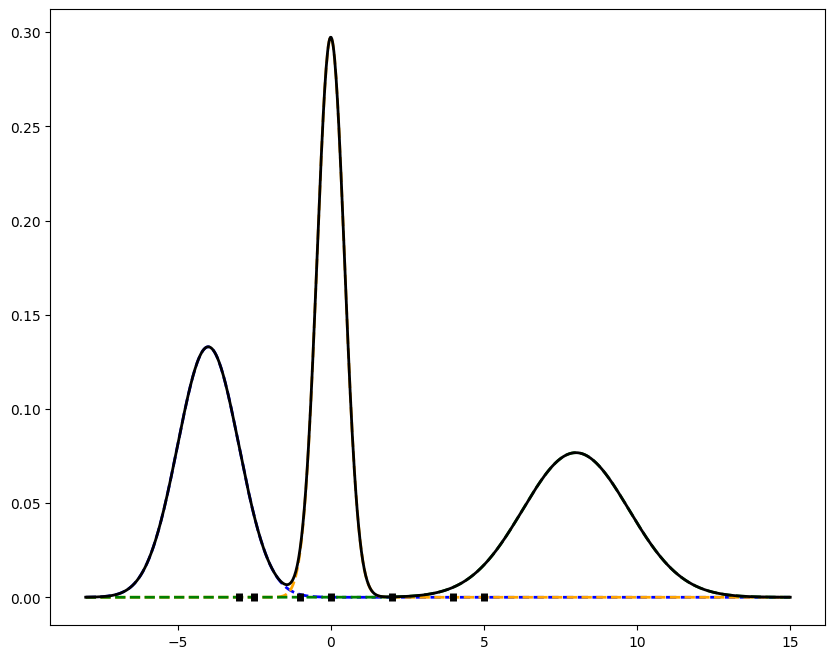

In [2]:
#Creamos el soporte
sup = np.linspace(-8, 15, 1000)[:, np.newaxis]

#Creamos los 3 Componentes
Componente1 = (1 / 3) *scipy.stats.norm(-4, 1).pdf(sup)
Componente2 = (1 / 3) *scipy.stats.norm(0, np.sqrt(0.2)).pdf(sup)
Componente3 = (1 / 3) * scipy.stats.norm(8, np.sqrt(3)).pdf(sup)

#Definimos la MMG
mmg = Componente1+Componente2+Componente3

#Muestra observada
X = np.array([-3,-2.5,-1,0,2,4,5])

#Graficamos la densidad
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sup, Componente1, '--', linewidth=2,color="blue")
ax.plot(sup, Componente2, '--', linewidth=2,color="orange")
ax.plot(sup, Componente3, '--', linewidth=2,color="green")
ax.plot(sup, mmg, '-', linewidth=2,color="black")
ax.plot(X, np.full_like(X, 0), '|k', markeredgewidth=5)
plt.show()

En el proceso queremos encontrar los parámetros que mejor describen los datos $X$. Para ello utilizaremos "ingeniería reversa" a traves de máxima verosimilitud. En otras palabras, queremos obtener  los parámetros $\theta=\{\mu_{k},\Sigma_{k},\pi_{k}\}$ por máxima verosimilitud.

Partiendo de asumir que los datos son $iid$ y recordando que la función de densidad de la Normal está dada por:

\begin{align}
\mathcal{N}(x|\mu,\Sigma)=\det(2\pi\Sigma)^{-\frac{1}{2}}\,\exp(-\frac{1}{2}(x-\mu)'\Sigma^{-1}(x-\mu))
\end{align}

La función de log-verosimilitud es:

\begin{align}
\mathcal{L}&=\log f(X|\theta)+\lambda\left(\sum_{k=1}^{K}\pi_{k}-1\right) \\
&=\sum_{n=1}^{N}\mathcal{\log}f(x_{i}|\theta)+\lambda\left(\sum_{k=1}^{K}\pi_{k}-1\right) \\
&=\sum_{n=1}^{N}\log\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})+\lambda\left(\sum_{k=1}^{K}\pi_{k}-1\right)
\end{align}

Donde, la diferencia con la funciones comunes es que incorpora la restricción de que los pesos deben sumar uno.


Sin embargo, a diferencia de la estimación típica de máxima verosimilitud en este caso no es posible obtener una solución de forma cerrada. La solución para resolver este problema, es utilizar el algoritmo EM. La idea clave del algoritmo es actualizar un parámetro del modelo a la vez, mientras se mantienen fijos los demás.


Antes de mostrar intuitivamente cómo funciona la actualización de parámetros, definimos primero la cantidad:

\begin{align}
r_{ik} = \frac{\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})}{\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})}
\end{align}

Que llamaremos **responsabilidad** del componente de la mezcla k por el $i$-ésimo punto de la muestra. Por lo tanto, el componente va a tener una alta responsabilidad cuando el punto tienen una alta probabilidad de haber surgido de ese componente. Notemos además que este término no es otra cosa que un vector de probabilidades normalizado, lo que implica que $r_{ik}\geq0$ y $\sum_{k=1}^{K}r_{ik}=1$. Por lo tanto, la $r_{ik}$ representa la probabilidad de que esa observación $x_i$ haya sido generada por el $k$-ésimo componente de la mezcla. En el caso de nuestro ejemplo anterior la responsabilidad para cada observación será:


\begin{align}
\left(\begin{array}{ccc}
1 & 0 & 0\\
1 & 0 & 0\\
0.057 & 0.943 & 0\\
0 & 1 & 0\\
0 & 0.066 & 0.943\\
0 & 0 & 1\\
0 & 0 & 1
\end{array}\right)
\end{align}

Podemos ver entonces que la suma para cada fila es uno, y la $k$-ésima fila nos dá una idea de la responsabilidad del $k$-ésimo componente. Así podemos ver que el tercer componente (tercer columna) no es responsable por los primeros puntos, pero sí es responsable por los 3 restantes. La suma de las entradas de cada columna nos dá la responsabilidad del $k$-ésimo componente que representaremos con  $N_k$. En nuestro ejemplo tenemos: $N_1 = 2.057$, $N_2=2.009$ y $N_3=2.934$.

Con esta cantidad definida podemos ver cómo actualizamos cada uno de los parámetros.

#### Actualizando las medias

Partimos derivando respecto al parámetro a actualizar, asumiendo que los demás están constantes e igualando a cero:

\begin{align}
\frac{\partial\mathcal{\log}f(x_{i}|\theta)}{\partial\mu_k}=\frac{1}{f(x_{i}|\theta)}\frac{\partial f(x_{i}|\theta)}{\partial\mu_k} =0
\end{align}

Donde

\begin{align}
f(x_{i}|\theta)=\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})
\end{align}

Y

\begin{align}
\frac{\partial f(x_{i}|\theta)}{\partial\mu_{k}}=\sum_{k=1}^{K}\pi_{k}\frac{\partial\mathcal{N}(x|\mu_{k},\Sigma_{k})}{\partial\mu_{k}}=\sum_{k=1}^{K}\pi_{k}(x_{i}-\mu_{k})'\Sigma_{k}^{-1}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})
\end{align}

Por lo que

\begin{align}
\frac{\partial\mathcal{\log}f(x_{i}|\theta)}{\partial\mu_{k}}=\sum_{k=1}^{K}(x_{i}-\mu_{k})'\Sigma_{k}^{-1}\underset{r_{ik}}{\underbrace{\frac{\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})}{\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})}}}
\end{align}

El término $r_{ik}$ se denomina responsabilidad


\begin{align}
\sum_{i=1}^{n}r_{ik}\pi_{k}(x_{i}-\mu_{k})'\Sigma_{k}^{-1}&=0 \\
\sum_{i=1}^{n}r_{ik}x_{i}&=\sum_{i=1}^{n}r_{ik}\mu_{k}
\end{align}

\begin{align}
\mu_{k}^{*}&=\frac{\sum_{i=1}^{n}r_{ik}x_{i}}{\sum_{i=1}^{n}r_{ik}}=\frac{1}{N_{k}}\sum_{i=1}^{n}r_{ik}x_{i}
\end{align}

Donde definimos $\sum_{i=1}^{n}r_{ik}=N_{k}$ como la responsabilidad total del componente $k$-ésimo para la muestra completa.

Notemos que la actualización hace que la contribución a la media de cada observación esté dada por la responsabilidad $r_{ik}$. Por lo tanto, observaciones con alta responsabilidad en el correspondiente componente, ponderarán más en la media de ese componente.

Usando los datos de nuestro ejemplo, los valores actualizados de la media serán

\begin{align}
\mu_{1}^{0}=-4&\rightarrow\mu_{1}^{1}=-2.7 \\
\mu_{2}^{0}=0&\rightarrow\mu_{2}^{1}=-0.4 \\
\mu_{3}^{0}=8&\rightarrow\mu_{3}^{1}=3.7
\end{align}

Actualizando la gráfica anterior con estos parámetros tenemos:

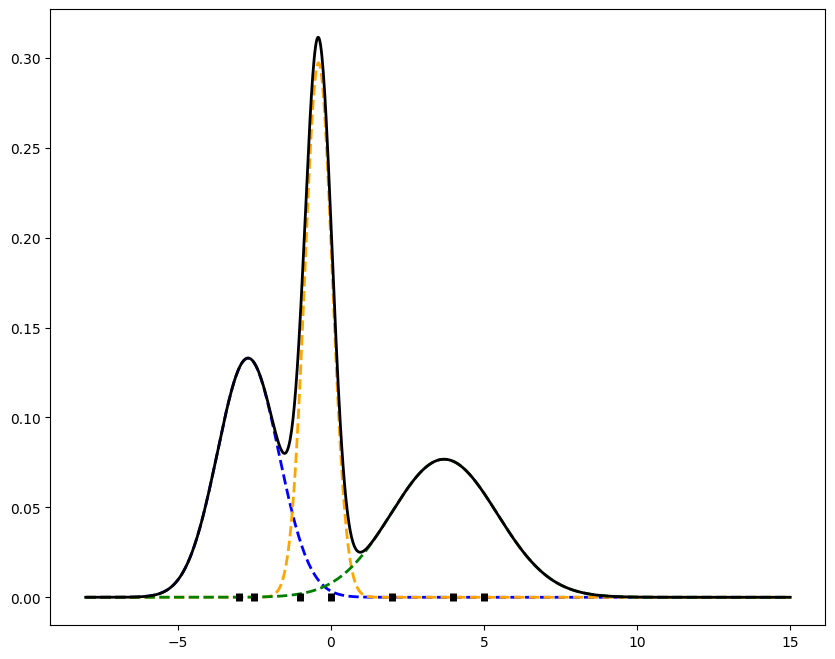

In [3]:
#Creamos los 3 Componentes con los parámetros actualizados
Componente1 = (1 / 3) *scipy.stats.norm(-2.7, 1).pdf(sup)
Componente2 = (1 / 3) *scipy.stats.norm(-0.4, np.sqrt(0.2)).pdf(sup)
Componente3 = (1 / 3) * scipy.stats.norm(3.7, np.sqrt(3)).pdf(sup)

#Definimos la MMG
mmg = Componente1+Componente2+Componente3

#Muestra observada
X = np.array([-3,-2.5,-1,0,2,4,5])

#Graficamos la densidad
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sup, Componente1, '--', linewidth=2,color="blue")
ax.plot(sup, Componente2, '--', linewidth=2,color="orange")
ax.plot(sup, Componente3, '--', linewidth=2,color="green")
ax.plot(sup, mmg, '-', linewidth=2,color="black")
ax.plot(X, np.full_like(X, 0), '|k', markeredgewidth=5)
plt.show()

Observemos acá, que los componentes 1 y 3 se movieron hacia el centro de los datos, mientras que el segundo componente casi no se mueve.

#### Actualizando las matriz de  covarianza

De igual manera podemos obtener la expresión que nos permite actualizar la covarianza (el algebra se los dejo como tarea):

\begin{align}
\frac{\partial\mathcal{L}}{\partial\Sigma_{k}}=0\iff\Sigma_{k}^{*}=\frac{1}{N_{k}}\sum_{i=1}^{n}r_{ik}(x_{i}-\mu_{k})(x_{i}-\mu_{k})'
\end{align}

Nuevamente vemos como las responsabilidades aparecen en la expresión y van a estar ponderando nuevamente los resultados. Para nuestro ejemplo, los valores actualizados de la varianza serán

\begin{align}
(\sigma^2)_{1}^{0}=1&\rightarrow(\sigma^2)_{1}^{1}=0.14 \\
(\sigma^2)_{2}^{0}=0.2&\rightarrow(\sigma^2)_{2}^{1}=0.44 \\
(\sigma^2)_{3}^{0}=3&\rightarrow(\sigma^2)_{3}^{1}=1.53
\end{align}

Actualizando la gráfica anterior con estos parámetros tenemos:

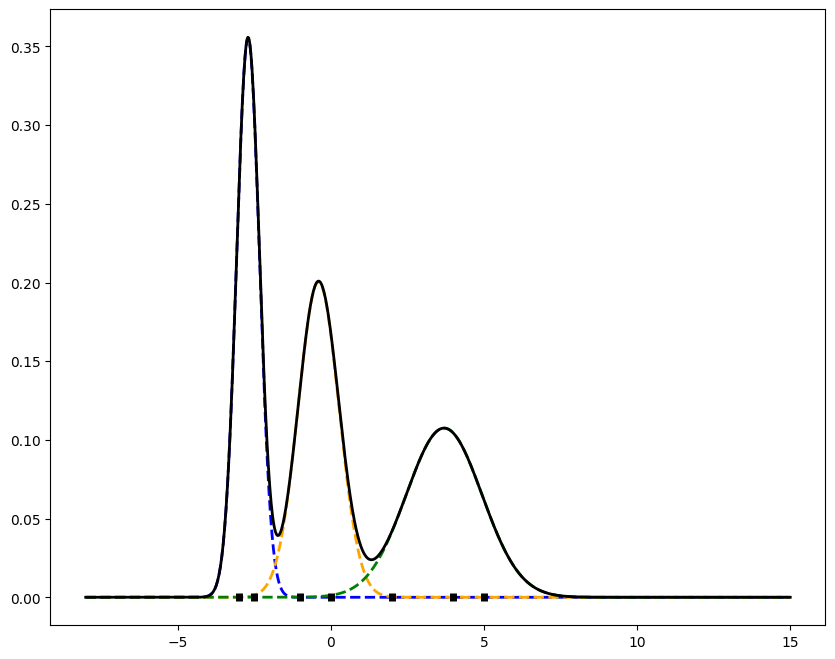

In [4]:
#Creamos los 3 Componentes con los parámetros actualizados
Componente1 = (1 / 3) *scipy.stats.norm(-2.7, np.sqrt(0.14)).pdf(sup)
Componente2 = (1 / 3) *scipy.stats.norm(-0.4, np.sqrt(0.44)).pdf(sup)
Componente3 = (1 / 3) * scipy.stats.norm(3.7, np.sqrt(1.53)).pdf(sup)

#Definimos la MMG
mmg = Componente1+Componente2+Componente3

#Muestra observada
X = np.array([-3,-2.5,-1,0,2,4,5])

#Graficamos la densidad
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sup, Componente1, '--', linewidth=2,color="blue")
ax.plot(sup, Componente2, '--', linewidth=2,color="orange")
ax.plot(sup, Componente3, '--', linewidth=2,color="green")
ax.plot(sup, mmg, '-', linewidth=2,color="black")
ax.plot(X, np.full_like(X, 0), '|k', markeredgewidth=5)
plt.show()

En este caso las varianzas del primer y tercer componente se agrandan y la del segundo se contrae levemente, haciendo que la varianza total de la mezcla sea menor.

#### Actualizando los pesos

Finalmente es turno de actualizar los pesos. Procedemos de manera similar pero teniendo en cuenta que ahora es importante no olvidar la restricción de que estos suman cero. Entonces tenemos:

\begin{align}
\frac{\partial\mathcal{L}}{\partial\pi_{k}}&=\sum_{n=1}^{N}\frac{\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})}{\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})}+\lambda \\
&=\frac{1}{\pi_{k}}\sum_{n=1}^{N}\frac{\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})}{\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x_{i}|\mu_{k},\Sigma_{k})}+\lambda \\
&=\frac{N_{k}}{\pi_{k}}+\lambda
\end{align}

Derivando con respecto a $\lambda$:

\begin{align}
\frac{\partial\mathcal{L}}{\partial\lambda}=\sum_{k=1}^{K}\pi_{k}-1
\end{align}

Por lo que $\sum_{k=1}^{K}\pi_{k}=1$ y $\lambda=-N$, entonces

\begin{align}
\pi_{k}^{*}=\frac{N_{k}}{N}
\end{align}

El peso entonces está dado por la responsabilidad del $k$-ésimo clúster y del número de datos. En nuestro ejemplo la actualización será:

\begin{align}
\pi_{1}^{0}&=\frac{1}{3}\rightarrow\pi_{1}^{1}=0.29 \\
\pi_{2}^{0}&=\frac{1}{3}\rightarrow\pi_{2}^{1}=0.29 \\
\pi_{3}^{0}&=\frac{1}{3}\rightarrow\pi_{3}^{1}=0.42
\end{align}

Vemos que el tercer componente recibe ahora más peso, mientras que los otros componentes se vuelven un poco menos importantes. Gráficamente:

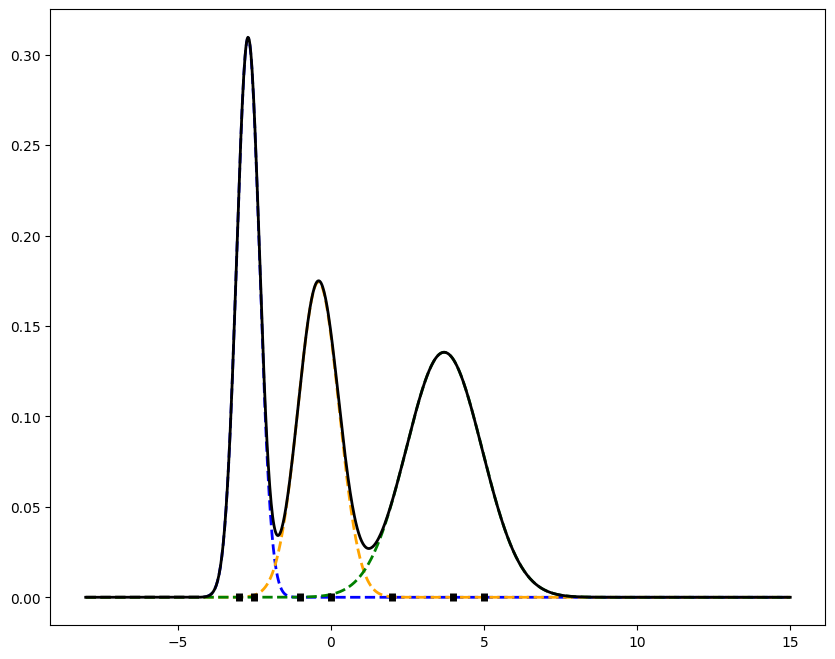

In [5]:
#Creamos los 3 Componentes con los parámetros actualizados
Componente1 = (.29) *scipy.stats.norm(-2.7, np.sqrt(0.14)).pdf(sup)
Componente2 = (.29) *scipy.stats.norm(-0.4, np.sqrt(0.44)).pdf(sup)
Componente3 = (.42) * scipy.stats.norm(3.7, np.sqrt(1.53)).pdf(sup)

#Definimos la MMG
mmg = Componente1 + Componente2 + Componente3

#Muestra observada
X = np.array([-3,-2.5,-1,0,2,4,5])

#Graficamos la densidad
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sup, Componente1, '--', linewidth=2,color="blue")
ax.plot(sup, Componente2, '--', linewidth=2,color="orange")
ax.plot(sup, Componente3, '--', linewidth=2,color="green")
ax.plot(sup, mmg, '-', linewidth=2,color="black")
ax.plot(X, np.full_like(X, 0), '|k', markeredgewidth=5)
plt.show()

Luego de actualizar las medias, las varianzas y los pesos una vez, obtenemos el MMG de la figura anterior. Si comparamos con nuestra propuesta inicial vemos que la actualizaciones provocaron que la densidad desplazara parte de su masa hacia donde están los puntos de la muestra. Si calculamos también el ajuste de la propuesta inicial (log-likelihood=28.3) versus luego de una iteración (log-likelihood=14.4) observamos que este ha mejorado considerablemente.

### Algoritmo EM

La sección anterior ilustra como es imposible obtener soluciones cerradas para los parámetros puesto que los gradientes envuelven las responsabilidades $r_{ik}$ que contienen no linealmente los parámetros a estimar. Sin embargo, en la sección anterior mostramos que podemos usar un proceso iterativo.

En esta sección discutiremos el algoritmo EM (*Expectation — Maximization algorithm*) que fue propuesto por Dempster et al.(1977). Este algoritmo es una extensión de lo que hicimos anteriormente.

Definamos  los pasos del algoritmo para MMG:

   1. Iniciar $\mu_k$, $\Sigma_k$ y $\pi_k$.
   2. *Paso-E*: evaluar las responsabilidades $r_{ik}$ para cada punto de datos usando los parámetros actuales.
   3. *Paso-M*: re-estimar los parámetros $\mu_k$, $\Sigma_k$ y $\pi_k$ usando las responsabilidades $r_{ik}$ encontradas en el paso anterior.
   4. Iterar hasta la convergencia de la función de log-verosimilitud. La forma de esta nos garantiza que siempre alcanzaremos al menos un mínimo local.
   
Mostremos entonces como implementar este algoritmo en `Python`, en datos bidimensionales. Para ello primero creemos datos ficticios. Notemos que cuando las distribuciones son bivariadas las medias son bidimensionales, y la varianza es una matriz. Definimos los parámetros para un MMG con 3 componentes:

In [6]:
# Medias
m = np.zeros((3,2))
m[0] = np.array([1.2, 0.4])
m[1] = np.array([-4.4, 1.0])
m[2] = np.array([4.1, -0.3])

# Covarianzas
S = np.zeros((3,2,2))
S[0] = np.array([[0.8, -0.4], [-0.4, 1.0]])
S[1] = np.array([[1.2, -0.8], [-0.8, 1.0]])
S[2] = np.array([[1.2, 0.6], [0.6, 3.0]])

# Pesos
w = np.array([0.3, 0.2, 0.5])

Luego generamos los datos, cada componente va a tener 200 puntos. Cada componente va a estar generado por una distribución normal (gaussiana) bivariada con los parámetros definidos anteriormente.

In [7]:
N_comp = 200 # número por componente
N = N_comp*3 # número total de datos
x = []
y = []
for k in range(3):
    x_tmp, y_tmp = np.random.multivariate_normal(m[k], S[k], N_comp).T
    x = np.hstack([x, x_tmp])
    y = np.hstack([y, y_tmp])

data = np.vstack([x, y])

Podemos ahora graficar los datos y los componentes del MMG:

<ipython-input-8-c4b548b635f3>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, 'ko', alpha=0.3, color="orange")


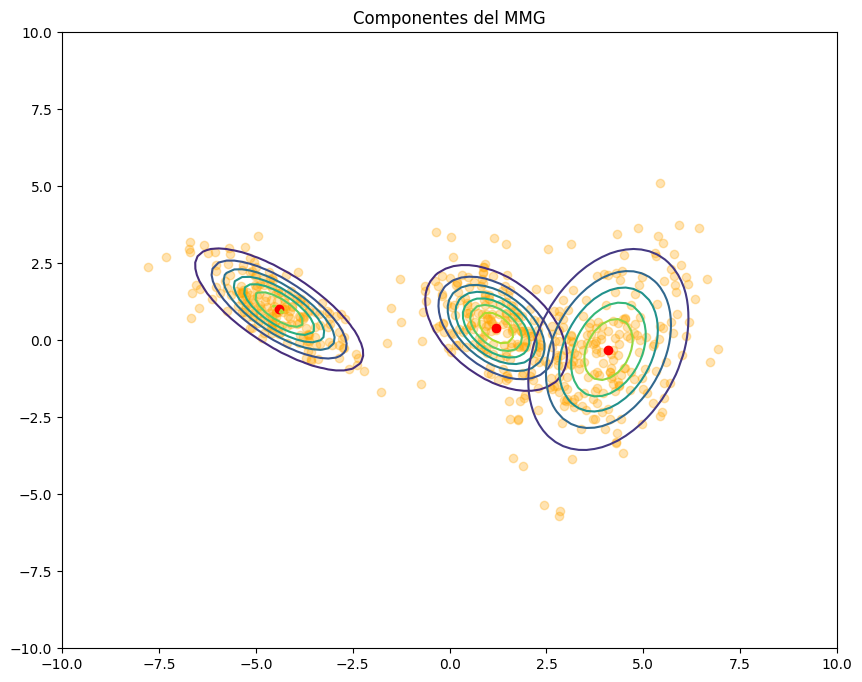

In [8]:
X, Y = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
pos = np.dstack((X, Y))

mvn = scipy.stats.multivariate_normal(m[0,:], S[0,:,:])
xx = mvn.pdf(pos)

# Graficamos los puntos
plt.figure()
plt.title("Componentes del MMG")
plt.plot(x, y, 'ko', alpha=0.3, color="orange")

# Graficamos los componentes
plt.plot(m[:,0], m[:,1], 'or')

for k in range(3):
    mvn = scipy.stats.multivariate_normal(m[k,:].ravel(), S[k,:,:])
    xx = mvn.pdf(pos)
    plt.contour(X, Y, xx,  alpha = 1.0, zorder=10)


Grafiquemos ahora el MMG

<ipython-input-9-fc2fd0ab7c1b>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, 'ko', alpha=0.3, color="orange")


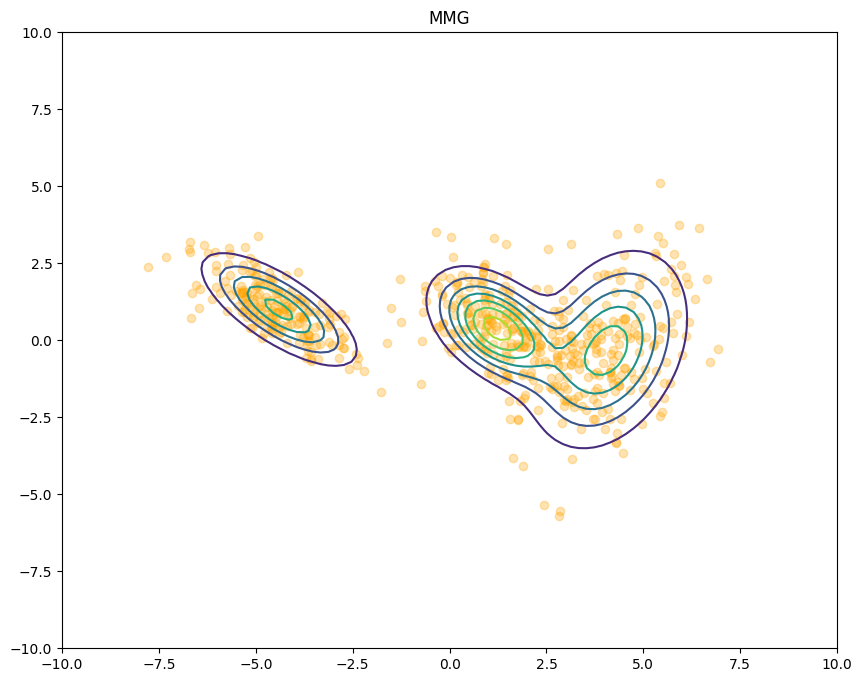

In [9]:
plt.figure()
plt.title("MMG")
plt.plot(x, y, 'ko', alpha=0.3, color="orange")

# MMG
mmg = 0
for k in range(3):
    mix_comp = scipy.stats.multivariate_normal(m[k,:].ravel(), S[k,:,:])
    mmg += w[k]*mix_comp.pdf(pos)

plt.contour(X, Y, mmg,  alpha = 1.0, zorder=10);

**Implementemos ahora el algoritmo EM:**

##### Iniciamos los parámetros

En este caso vamos a iniciar con medias aleatorias, una matriz de covarianza igual a la identidad, e igual peso a todos los componentes. Los parámetros donde iniciamos son importantes y por lo tanto es recomendable verificar que hacen las funciones ya programadas en los distintos softwares. Por ejemplo, en algunos casos se puede utilizar los centroides estimados por `K-medias` para iniciar el MMG (los invito a que modifiquen el código de abajo con esta implementación):

In [10]:
K = 3 # número de mezclas

means = np.zeros((K,2))
covs = np.zeros((K,2,2))
for k in range(K):
    means[k] = np.random.normal(size=(2,))
    covs[k] = np.eye(2)

weights = np.ones((K,1))/K
print("Vector inicial de medias (una por fila):\n" + str(means))

Vector inicial de medias (una por fila):
[[ 0.14222676  0.3849668 ]
 [-0.84109802  0.3836126 ]
 [-0.93175633 -0.08802176]]


In [11]:
print("Vector inicial de covarianzas:\n" + str(covs))

Vector inicial de covarianzas:
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


In [12]:
print("Vector inicial de pesos:\n" + str(weights))

Vector inicial de pesos:
[[0.33333333]
 [0.33333333]
 [0.33333333]]


Grafiquemos entonces el MMG resultante de estos parámetros iniciales:

<ipython-input-13-5bb1141d0215>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, 'ko', alpha=0.3, color="orange")


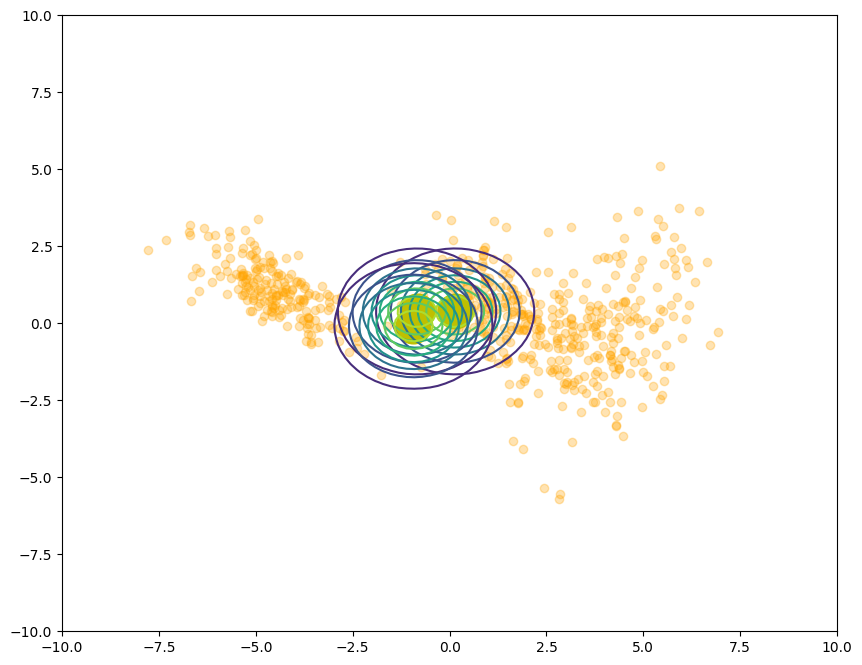

In [13]:
NLL = [] # función log-verosimilitud de MMG
gmm_nll = 0
for k in range(K):
    gmm_nll += weights[k]*scipy.stats.multivariate_normal.pdf(mean=means[k,:], cov=covs[k,:,:], x=data.T)
NLL += [-np.sum(np.log(gmm_nll))]

plt.figure()
plt.plot(x, y, 'ko', alpha=0.3, color="orange")
plt.plot(means[:,0], means[:,1], 'oy', markersize=25)

for k in range(K):
    rv = scipy.stats.multivariate_normal(means[k,:], covs[k,:,:])
    plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)


Con estos parámetros iniciales estamos todavía lejos de tener una buena estimación del modelo.

Escribamos ahora una función que implemente el algoritmo EM:

In [14]:
r = np.zeros((K,N)) # vector que va a guardar las responsabilidades

for em_iter in range(100):
    means_old = means.copy()

    # Paso-E: actualizamos las responsibilidades
    for k in range(K):
        r[k] = weights[k]*scipy.stats.multivariate_normal.pdf(mean=means[k,:], cov=covs[k,:,:], x=data.T)

    r = r/np.sum(r, axis=0)

    # Paso-M: actualizamos los parámetros
    N_k = np.sum(r, axis=1) #calculamos Nk

    for k in range(K):
        # Actualizamos medias
        means[k] = np.sum(r[k]*data, axis=1)/N_k[k]

        # Actualizamos covarianzas
        diff = data - means[k:k+1].T
        _tmp = np.sqrt(r[k:k+1])*diff
        covs[k] = np.inner(_tmp, _tmp)/N_k[k]

    # Actualizamos pesos
    weights = N_k/N

    # Calculamos la log-verosimilitud
    gmm_nll = 0
    for k in range(K):
        gmm_nll += weights[k]*scipy.stats.multivariate_normal.pdf(mean=means[k,:].ravel(), cov=covs[k,:,:], x=data.T)
    NLL += [-np.sum(np.log(gmm_nll))]

    # Esta parte es opcional y gráfica cada una de las iteraciones
    #plt.figure()
    #plt.plot(x, y, 'ko', alpha=0.3, color="orange")
    #plt.plot(means[:,0], means[:,1], 'oy', markersize=25)
    #for k in range(K):
    #    rv = multivariate_normal(means[k,:], covs[k])
    #    plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)
    #plt.text(x=3.5, y=8, s="Iteración EM  "+str(em_iter+1))

    # Verificamos la convergencia del algoritmo, decimos que este convergió si la diferencia entre las log-verosimilitudes es menor a 1e-6
    if scipy.linalg.norm(NLL[em_iter+1]-NLL[em_iter]) < 1e-6:
        print("Convergió después de ", em_iter+1, " iteraciones")
        break


Nuestro algoritmo convergió luego de 62 iteraciones, podemos visualizar la log-verosimilitud si alcanzó un mínimo:

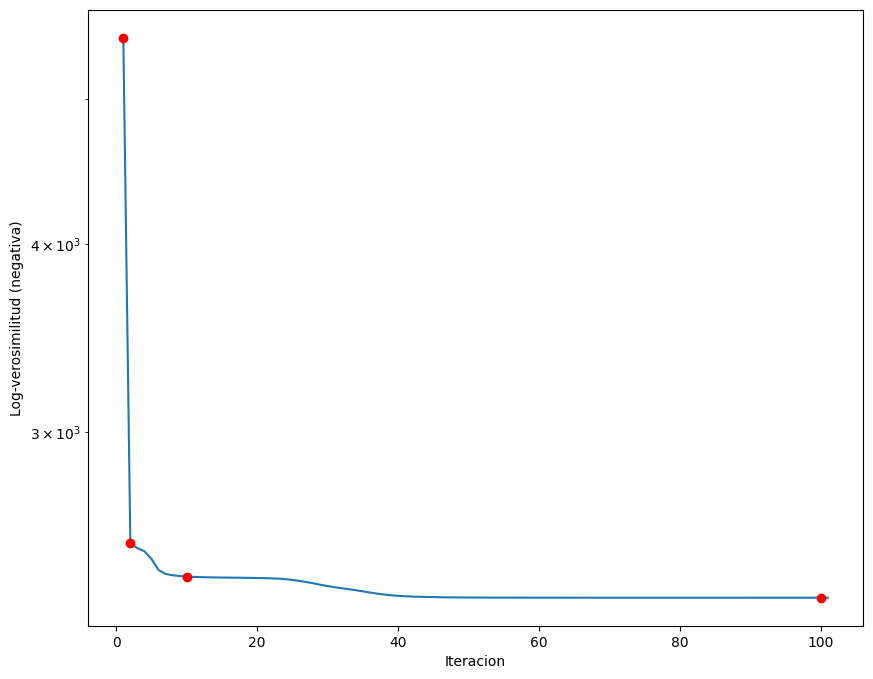

In [15]:
plt.figure()
plt.semilogy(np.linspace(1,len(NLL), len(NLL)), NLL)
plt.xlabel("Iteracion");
plt.ylabel("Log-verosimilitud (negativa)");

idx = [0, 1, 9, em_iter]

for i in idx:
    plt.plot(i+1, NLL[i], 'or')

Veamos la estimación resultante:

<ipython-input-16-d93c85dc5781>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, 'ko', alpha=0.3,color="orange")


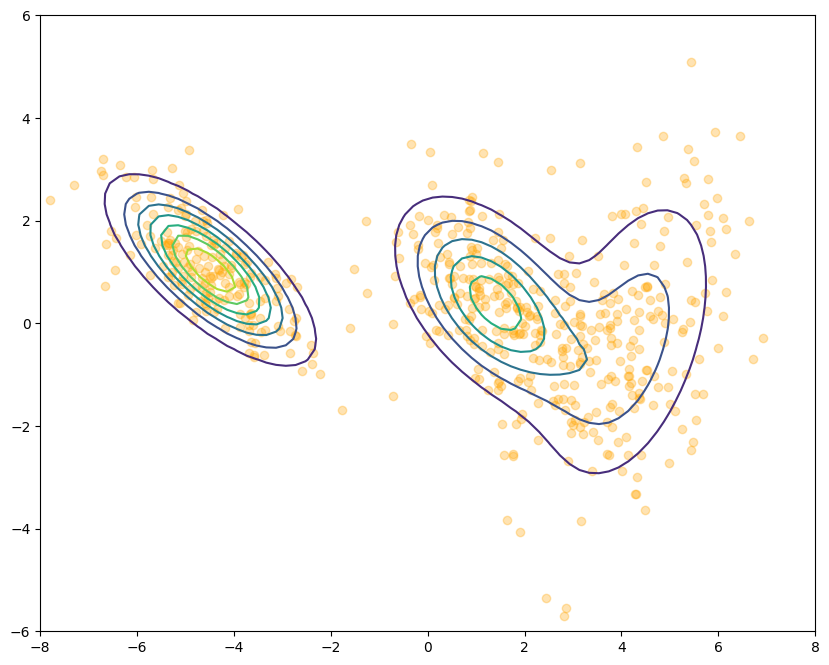

In [16]:
plt.figure()
gmm = 0
for k in range(3):
    mix_comp = scipy.stats.multivariate_normal(means[k,:].ravel(), covs[k,:,:])
    gmm += weights[k]*mix_comp.pdf(pos)

plt.plot(x, y, 'ko', alpha=0.3,color="orange")
plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10)
plt.xlim([-8,8]);
plt.ylim([-6,6]);

Si comparamos esta estimación con los verdadera distribución subyacente, vemos que el algoritmo hizo un muy buen trabajo.

#### EM  con `sklearn`

En la práctica, no es necesario escribir nuestra propia función, la librería `Scikit-learn` contiene la función de [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) que implementa el algoritmo EM para obtener el MMG. La ventaja del uso de esta librería es que los algoritmos son más eficientes y están optimizados; por lo que suelen correr más rápido y con menos errores. Su implementación es sencilla y entre sus parámetros se destacan:

   - `n_components`: determina el número de $K$ componentes a estimar.

   - `covariance_type`: la forma de la covarianza de los componentes. Este parámetro es importante porque va a determinar la forma de cada componente; por ejemplo, cuan "alargado" o esférico son. En la función existen 4 opciones:
   
         - tied: todas las componentes comparten la misma matriz de covarianza.         
         - spherical: cada componente tiene su propia varianza, esta opción permite generar componentes de distintos tamaño pero esféricas        
         - diag: cada componente tiene su propia matriz de covarianza diagonal, es decir las covarianzas son cero.
         - full: cada componente tiene su propia matriz de covarianza completa. Esta opción es la más flexible pero también la más demandante computacionalmente.
    

   - `init_params`: determina cómo va a iniciar los parámetros, las opciones disponibles es hacerlo `aleatoriamente (random)`, como lo hicimos en la sección anterior, o utilizando `K-medias (k-means)`.


Si bien tiene varios parámetros, estos tienen ciertos valores iniciales y podemos ejecutar la función al igual que la de K-medias simplemente especificando el número de componentes y de la semilla (usted puede modificar y experimentar qué sucede cuando se cambian los otros parámetros).


In [17]:
from sklearn.mixture import GaussianMixture

X = np.c_[x, y]
MMG_3 = GaussianMixture(n_components = 3, random_state = 1234).fit(X)

El método `fit` estima los parámetros de los componentes y `fit_predict`, computa los componentes y predice el componente al que pertenece cada observación. Visualicemos los componentes:

In [24]:
#Definimos una función que nos permite crear las curvas de nivel a través de elipses:

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Dibuja un elipse dado la media y varianza"""
    ax = ax or plt.gca()

    # Convierte las covarianzas
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Dibuja el elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

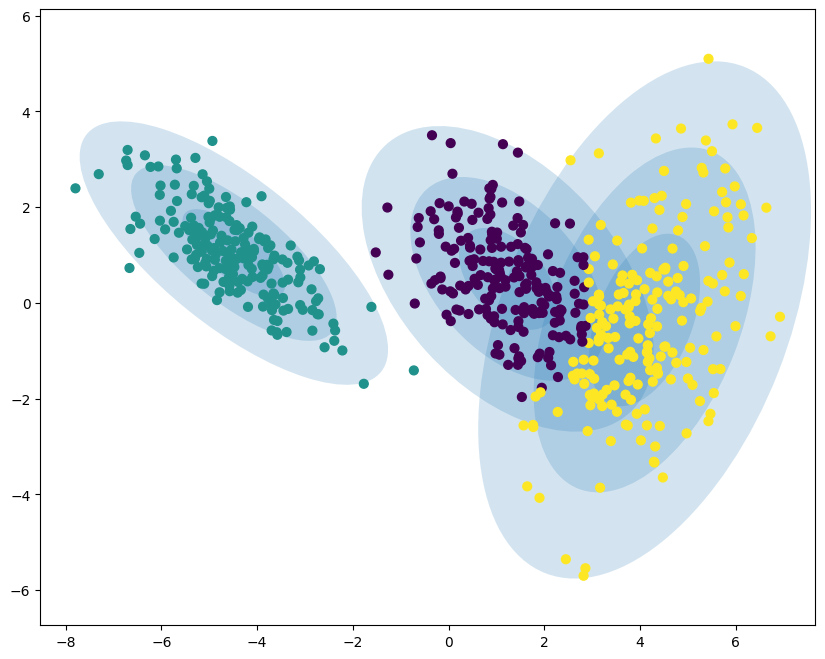

In [25]:
# Graficamos
plot_gmm(MMG_3, X)

Vemos entonces que esta función no solo nos permite obtener los 3 componentes sino también clasificar cada observación a uno de ellos. Esto sugiere que MMG puede servir como algoritmo de clustering similar a `K-medias`.

## ¿Cuántos componentes?

Hasta este momento omitimos la discusión de cuantos son los componentes a estimar. El hecho de que MMG sea un modelo probabilístico simplifica esta tarea. Esto se debe a que tenemos medidas de ajuste que nos permiten tener una idea de cuales son los parámetros que mejor ajustan el modelo.

La medida más intuitiva es utilizar la verosimilitud del modelo, sin embargo esta no penaliza por la complejidad del modelo y nos podría llevar a sobre-ajustar el modelo.

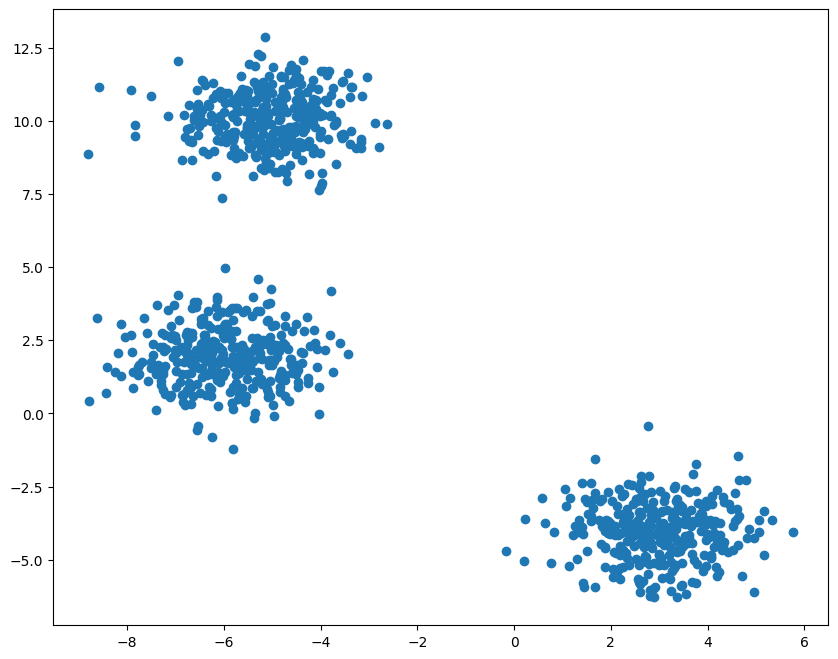

In [26]:
#Cargamos las librerías a utilizar
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples = 1000, n_features = 2, centers = [[-6,2],[3,-4],[-5,10]], random_state = 123)

plt.scatter(X[:,0],X[:,1])

Estimemos el modelo para distintos números de componentes y evaluemos el negativo de su verosimilitud:

Text(0.5, 0, 'Número de componentes')

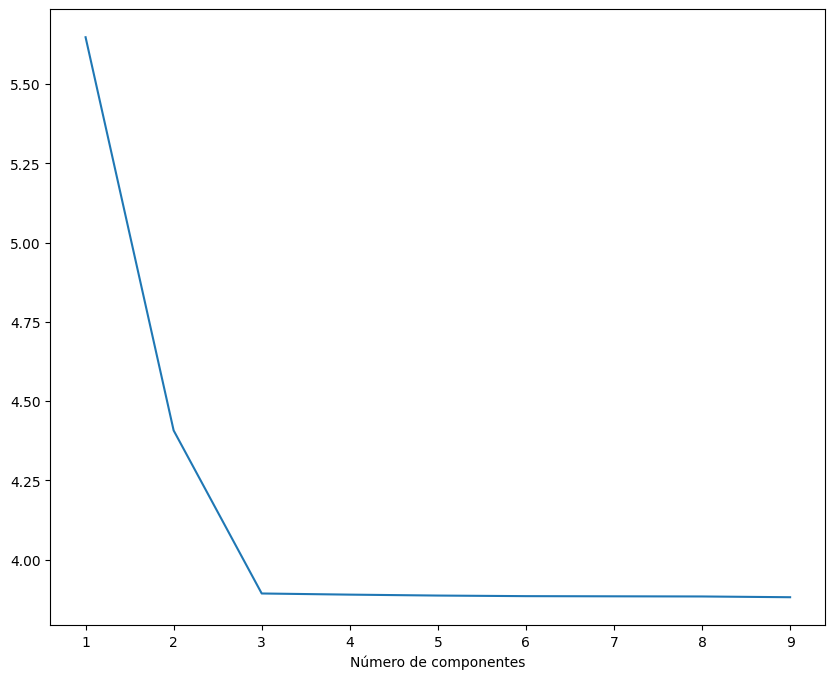

In [27]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=3).fit(X)
          for n in n_components]

plt.plot(n_components, [-m.score(X) for m in models], label='Log-Verosimilitud (neg)')
plt.xlabel('Número de componentes')

Vemos en este caso que la log verosimilitud parece llegar a un mínimo de 3 componentes, sin embargo sigue disminuyendo con más componentes. Una forma de evitar el sobre-ajuste es hacer validación cruzada y los invito a que la implementen.  

Una segunda forma es utilizar  algún criterio analítico como el criterio que penalice por la complejidad. Por ejemplo el criterio de información de Akaike (AIC) que penaliza por el número de parámetros a estimar o el criterio de información Bayesiano (BIC) que además de penalizar por el número de parámetros a estimar penaliza también por el número de observaciones. La ventaja de utilizar estos dos criterios es que están integrados en la función `GaussianMixture`:

Text(0.5, 0, 'Número de componentes')

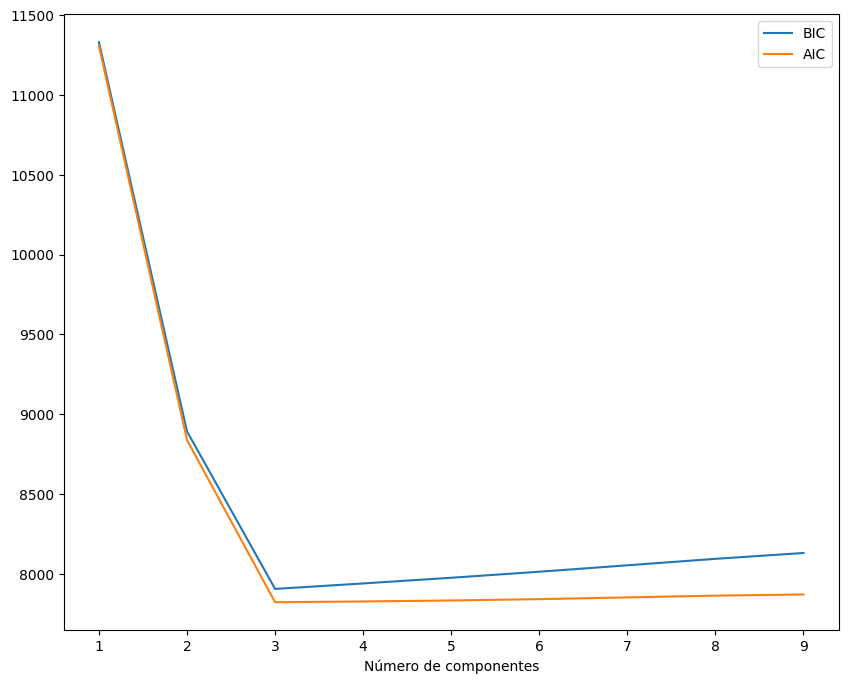

In [28]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=3).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('Número de componentes')


Vemos en este caso sencillo que la log-verosimilitud es mínima con 3 componentes independientemente de los criterios.

Sin embargo veamos que sucede cuando la forma de los componentes es más complicada. Para ello haremos grupos con forma de lunas:

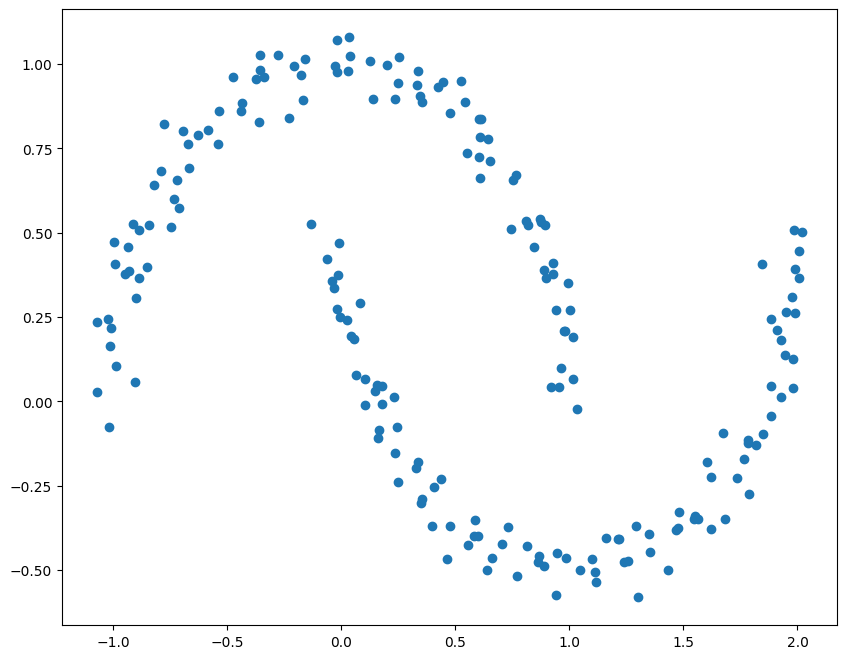

In [29]:
from sklearn.datasets import make_moons
Xluna, yluna = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xluna[:, 0], Xluna[:, 1]);

Si pensamos MMG como un algoritmo de clustering, en este caso no vamos a tener resultados particularmente útiles:

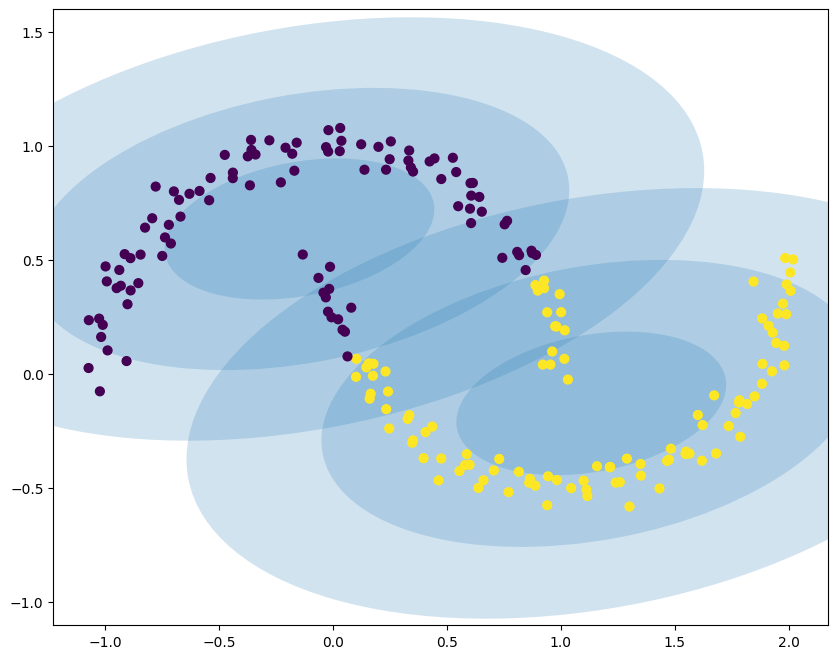

In [30]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xluna)

Sin embargo, si utilizamos muchos más e ignoramos los componentes, vamos a ver que podemos modelar los datos más eficientemente:

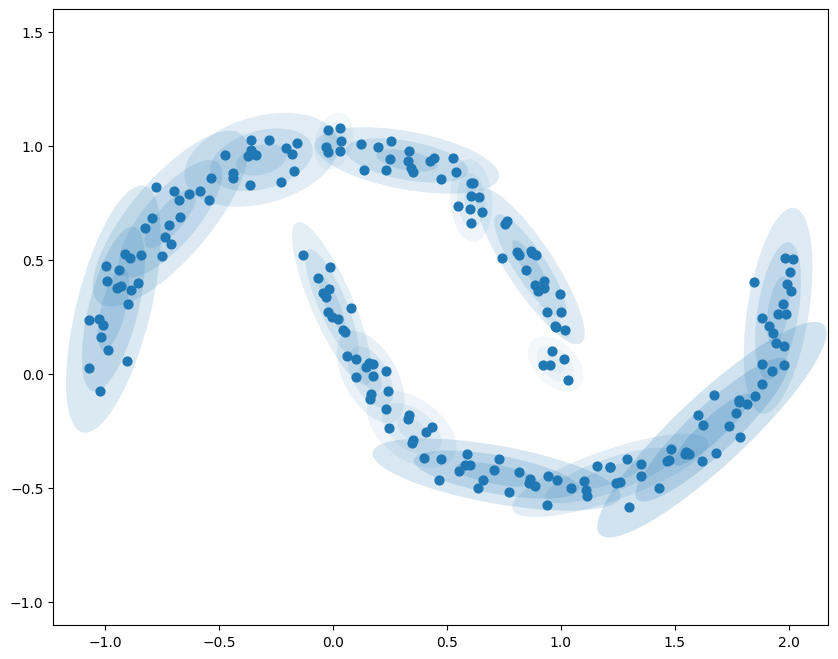

In [31]:
MMG16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(MMG16, Xluna, label=False)

El gráfico anterior nos muestra que con la mezcla de 16 componentes no hacemos un buen trabajo encontrando clústeres, pero si modelando la distribución general de los datos. Adicionalmente, al ser un modelo probabilístico, tenemos los parámetros que nos permiten generar nuevas observaciones con la misma distribución subyacente.

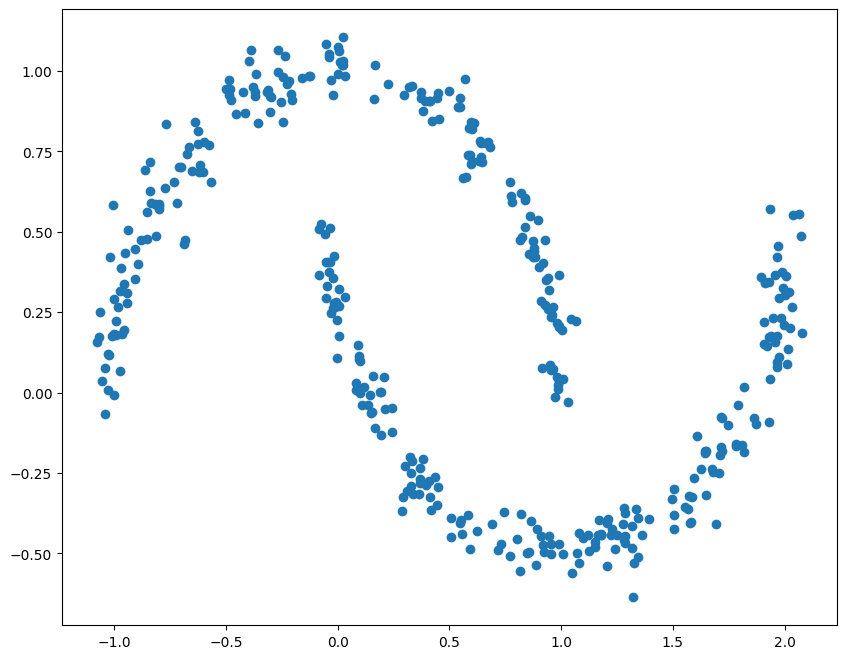

In [32]:
#Generamos 400 puntos nuevos a partir del MMG estimado anteriormente
Xnuevo, Ynuevo  = MMG16.sample(400)

plt.scatter(Xnuevo[:, 0], Xnuevo[:, 1])

MMG es entonces una forma flexible paramétrica para modelar la distribución de datos multidimensional. Veamos, sin embargo, cuál es el número óptimo de componentes en este caso:

Text(0.5, 0, 'Número de componentes')

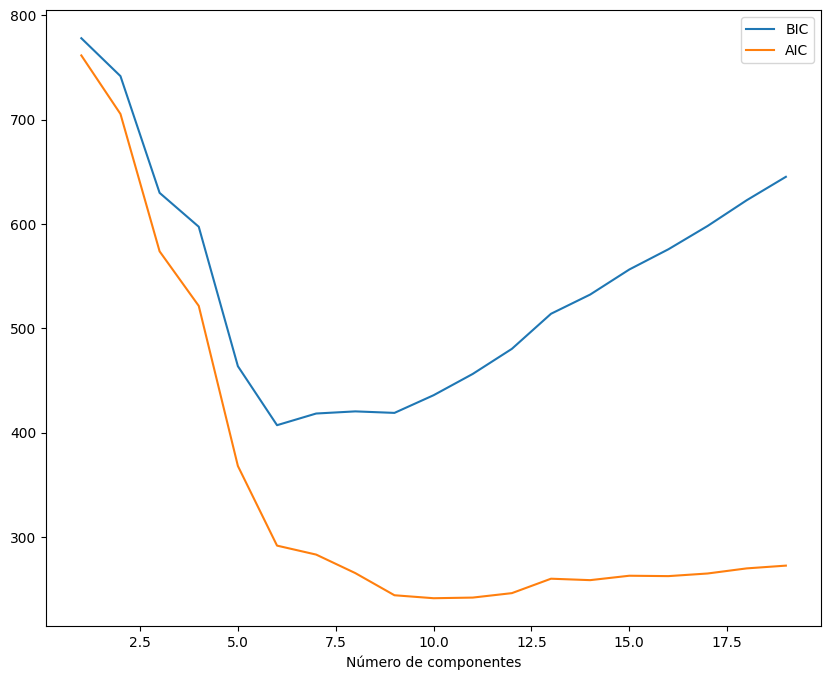

In [33]:
n_components = np.arange(1, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=3).fit(Xluna)
          for n in n_components]

plt.plot(n_components, [m.bic(Xluna) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xluna) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('Número de componentes')


Notemos que en este caso los criterios difieren en el número óptimo de componentes. El AIC nos dice que nuestra elección de los 16 componentes anteriores probablemente fue demasiado: entre 8 y 12 componentes habría sido una mejor opción, mientras que  BIC recomienda un modelo más pequeño. La elección dependerá de la experiencia y el problema que enfrenta el analista.

Sin embargo, es muy importante resaltar que para la elección de número de componentes estamos midiendo cuán bien ajusta MMG como estimador de densidad, no qué tan bien funciona como algoritmo de clústeres. Es decir, si bien podemos usar MMG como un algoritmo de clustering, este principalmente es un estimador de densidad. En la siguiente sección estudiaremos cómo podemos usar este algoritmo como un algoritmo de clustering y su ventaja sobre K-medias.

## MMG como algoritmo de clustering y su comparación con K-medias

En la sección anterior vimos que MMG puede servir como algoritmo de clustering. En esta sección la compararemos con `K-medias` y veremos en qué casos MMG puede ser una mejor opción.

En el *cuaderno: Clustering: K-medias. Fundamentos Teóricos* vimos que con datos simples, bien comportados y separados, `K-medias`  es muy eficiente. Consideremos el siguiente caso con datos ficticios y con cierto solapamiento:

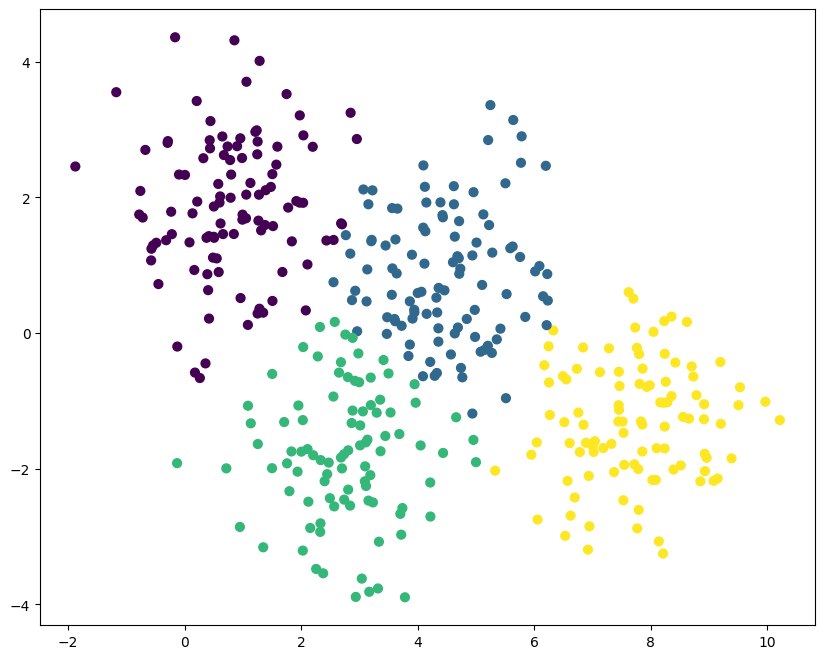

In [34]:
# Generamos algunos datos ficticios
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=1, random_state=0)
X = X[:, ::-1] # damos vuelta los ejes

# Usamos K-means para encontrar los clústeres.
kmeans = KMeans(4, random_state=123)
labels = kmeans.fit(X).predict(X)

# Graficamos los resultaods
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Como vimos anteriormente, en este tipo de situaciones, `K-means` hace un  buen trabajo. Sin embargo, intuitivamente uno podría esperar que la asignación a un clúster dado sea más segura que para otros. Por ejemplo, en el gráfico anterior para los dos clústeres en el centro de la figura parece haber una leve superposición de los clústeres, y por lo tanto es posible que no exista confianza total en la asignación.

K-medias, sin embargo no tiene una medida intrínseca de probabilidad o incertidumbre. Una forma en que podemos pensar a K-medias es como un modelo que coloca un círculo (o hiper-esfera en dimensiones mayores) con centro en la media del clúster y radio definido por el punto más lejano del clúster. Este radio es el que marca la asignación al clúster. Veamos como quedaría en nuestro ejemplo:

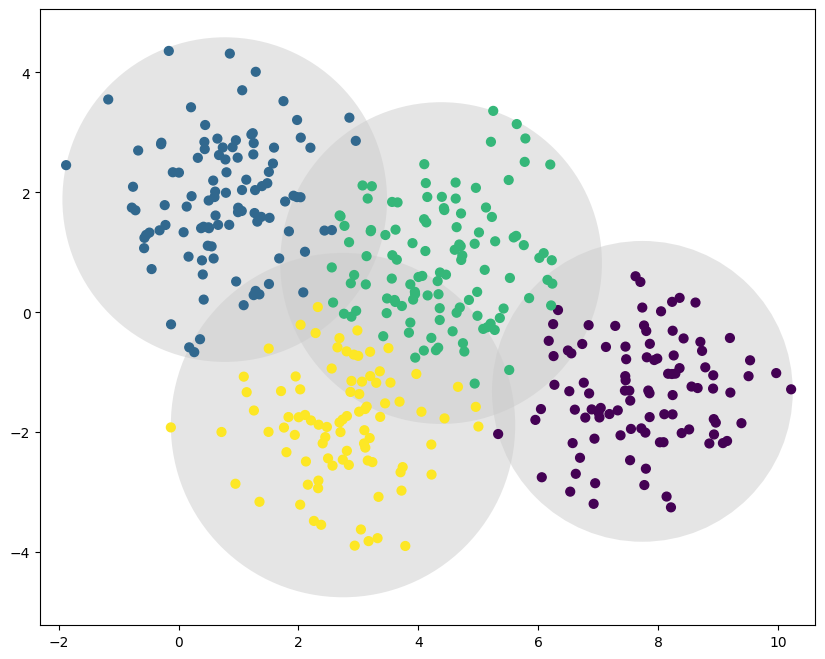

In [35]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # Grafiquemos la data que aportamos
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # Grafiquemos la representación del modelo de K-Means
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))


kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Vemos como se solapan las áreas de asignación en los clústeres. Puntos en la intersección de los círculos podrían pertenecer a uno u otro clúster y sería bueno tener una medida de probabilidad. MMG pueden en casos como estos superar esta limitación de K-medias:

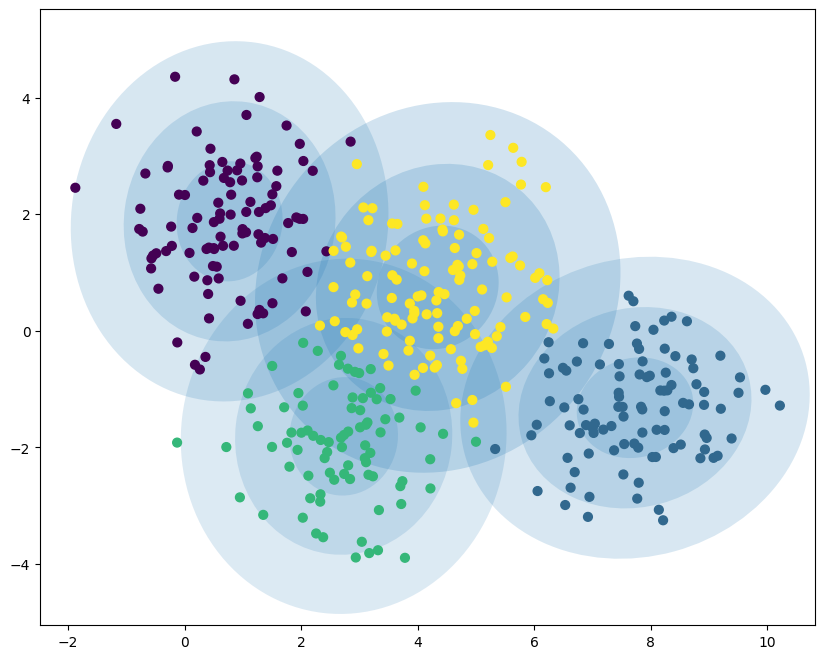

In [36]:
MMG_k = GaussianMixture(n_components=4)
plot_gmm(MMG_k, X)

Podemos obtener las probabilidades de pertenecer a cada componente usando el método `predict_proba`. Para ilustrar esto, nos concentraremos en un grupo de puntos en el área de solapamiento:

In [37]:
Xnew=X[X[:,1]>-1]
Xnew=Xnew[Xnew[:,0]<2.6]
Xnew=Xnew[Xnew[:,0]>2]
Xnew.shape

(13, 2)

Calculemos las probabilidades:

In [38]:
probs= MMG_k.fit(Xnew).predict_proba(Xnew)
probs

array([[0.00000000e+000, 7.08065344e-025, 1.77471641e-002,
        9.82252836e-001],
       [0.00000000e+000, 1.31358644e-090, 1.00000000e+000,
        1.62545898e-054],
       [0.00000000e+000, 1.28329241e-006, 1.48447730e-003,
        9.98514239e-001],
       [0.00000000e+000, 9.99998632e-001, 1.36717349e-006,
        5.67096853e-010],
       [0.00000000e+000, 9.99999966e-001, 3.38864231e-008,
        4.81818762e-042],
       [0.00000000e+000, 1.88213518e-089, 1.00000000e+000,
        6.07975686e-099],
       [9.99998917e-001, 1.23719895e-200, 1.08319296e-006,
        6.87317790e-260],
       [0.00000000e+000, 9.99988559e-001, 1.14409520e-005,
        1.23777158e-011],
       [0.00000000e+000, 7.52610527e-009, 2.21639867e-003,
        9.97783594e-001],
       [0.00000000e+000, 5.69344946e-033, 1.00000000e+000,
        1.89013798e-020],
       [9.99997113e-001, 3.83149144e-208, 2.88720875e-006,
        1.05736921e-237],
       [0.00000000e+000, 2.94955722e-107, 1.00000000e+000,
      

Esto muestra que para ciertos puntos en las áreas de solapamiento, tenemos ahora una medida de probabilidad que nos dice la confianza en la asignación.

Una de las limitaciones que notamos para K-medias es que tiene dificultades cuando los clústeres son alargados o con formas irregulares. Para mostrarlo, transformemos los datos anteriores de forma tal que tengan una forma alargada:

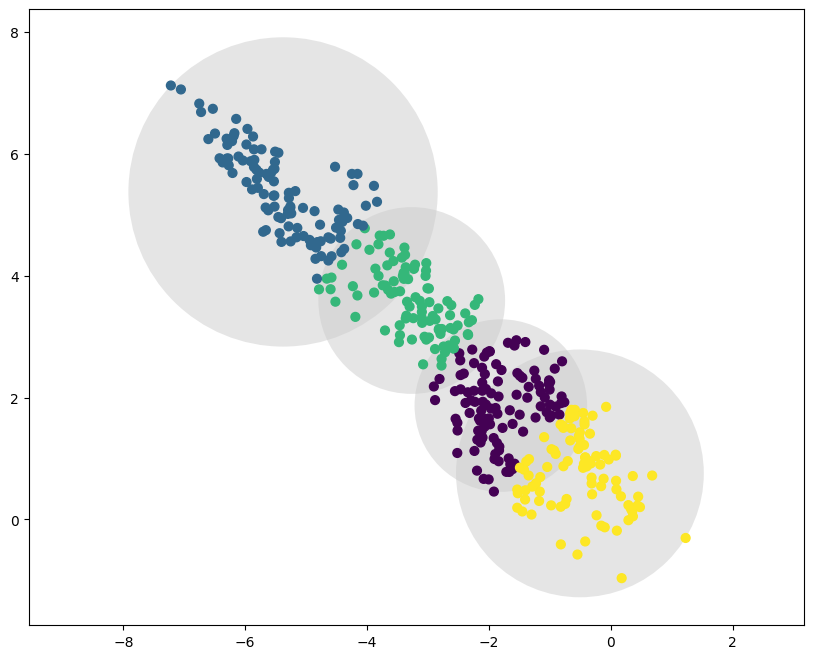

In [39]:
rng = np.random.RandomState(13)
X_alargados = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=123)
plot_kmeans(kmeans, X_alargados)

La gráfica de arriba muestra entonces los clústeres transformados donde podemos ver que los datos no son circulares y, por lo tanto, los clústeres circulares no son un buen ajuste. Sin embargo, K-medias no reconoce esto y fuerza el ajuste de los datos en cuatro clústeres circulares. Esto dá como resultado una mezcla de asignaciones de clústeres donde los círculos resultantes se superponen, especialmente la parte superior de la gráfica.

MMG sin embargo no sufre de estas limitaciones y permite ajustar datos no esféricos. Veamos entonces como cambia la asignación:

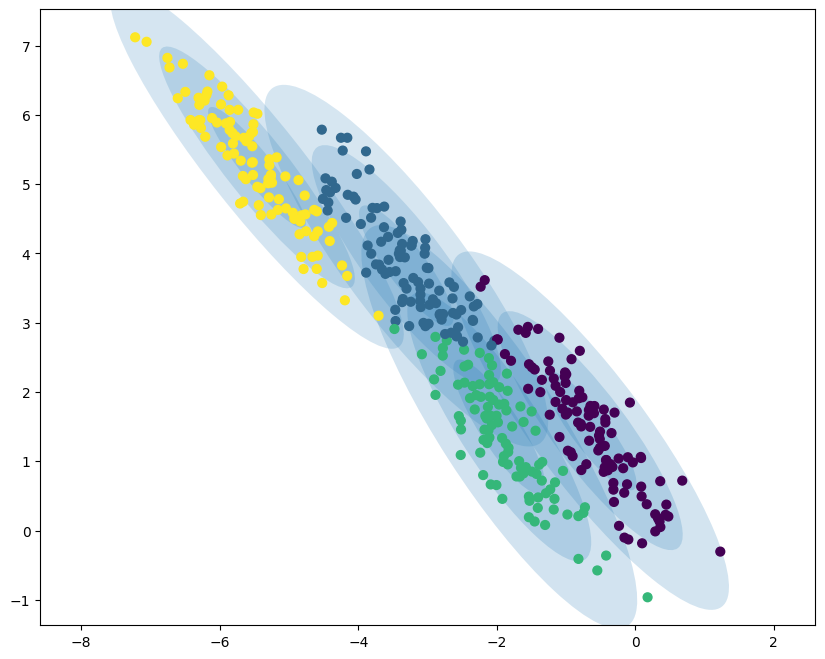

In [40]:
MMG_alargados = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(MMG_alargados, X_alargados)

Claramente los clústeres asignados son muy distintos a los obtenidos por K-medias, siendo ahora alargados.

La última limitación que enumeramos de K-medias tenía que ver con la robustez frente a valores atípicos y outliers. MMG al ser un modelo probabilístico, uno puede obtener probabilidades como vimos anteriormente. Estas probabilidades pueden ser utilizadas para detectar valores atípicos.


Veamos entonces como podemos hacerlo, para ello comenzamos utilizando el método `score_Samples` que computa la log-verosimilitud de cada observación:

In [41]:
log_probab_pred = MMG_alargados.score_samples(X=X_alargados)

Luego para facilitar el análisis y visualización vamos a transformar los datos a un `DataFrame` de `pandas`:

In [42]:
# Cargamos la libreria a utilizar
import pandas as pd

# Ponemos los datos en una DataFrame
df = X_alargados.copy()
df=pd.DataFrame(df, columns = ['X1','X2'])


Agregamos una columna con la probabilidad predicha:

In [43]:
df['probabilidad_pred'] = np.exp(log_probab_pred)


Ordenamos los resultados de menor a mayor visualizando los 10 primeros:

In [44]:
df = df.sort_values(by='probabilidad_pred')
outliers = df.head(10)
outliers

,X1,X2,probabilidad_pred
161,0.176786,-0.963839,0.000779
275,1.226457,-0.304369,0.001894
235,0.677176,0.720165,0.003711
197,-0.078339,1.847158,0.004519
84,-3.888321,5.473792,0.006261
171,-7.220786,7.120494,0.006754
271,-4.157826,5.669948,0.006810
85,-2.520809,1.090212,0.007607
12,-2.174359,3.614392,0.008064
299,-0.157270,-0.102457,0.008383


Identificamos entonces 10 observaciones que tienen muy baja probabilidad de pertenecer al modelo. Obviamente en este caso no existe un corte mínimo y deberá ser especificado por el analista dependiendo la aplicación.

## MMG para análisis de puntos calientes

En el *cuaderno: Estimación de Densidades para el Análisis de Puntos Calientes. Fundamentos Teóricos* estudiamos como utilizar KDE para analizar puntos calientes geográficos. Puesto que MMG es intrínsecamente un método de estimación de densidades, podemos entonces utilizarlo para analizar puntos calientes geográficos.

Para ilustrarlo obtengamos datos de [OpenStreetMap](https://www.openstreetmap.org/) sobre teatros en Buenos Aires:

In [47]:
!pip install pyrosm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyrobuf-0.9.3-cp311-cp311-linux_x86_64.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.6 MB/s eta 0:00:00
  Created wheel for pyrosm: filename=pyrosm-0.6.2-cp311-cp311-linux_x86_64.whl size=7783800 sha256=bf611ea89398b2b0648e152efb480d2001776bfc4ff91dbc8f157dec979bfdf4
  Stored in directory: /root/.cache/pip/wheels/f3/77/c3/7b767c229a2bba06eb2e47fbce4cdbc4490b38d97f2a0ae64d
  Created wheel for cykhash: filename=cykhash-2.0.1-cp311-cp311-linux_x86_64.whl size=3602251 sha256=907aa614602ba51f470f7a5ed696b6f261f493c49050a7d64e6278a0ce2af54c

In [48]:
from pyrosm import OSM, get_data

# Bajamos los datos para  Buenos Aires
fp = get_data("Buenos Aires")

# Inicializamos el lector para Buenos Aires
osm = OSM(fp)

Downloaded Protobuf data 'BuenosAires.osm.pbf' (26.08 MB) to:
'/tmp/pyrosm/BuenosAires.osm.pbf'


In [49]:
#Obtenenemos los cafés
teatros = osm.get_pois(custom_filter={'amenity': ['theatre']})

Nos quedamos con teatros que aparecen como punto en la base y que no tienen faltantes en la longitud y la latitud:

In [50]:
teatros.dropna(subset=['lon', 'lat'])
teatros=teatros[teatros.geom_type=="Point"]
teatros.head()

,tags,changeset,lon,version,id,timestamp,lat,visible,addr:city,addr:country,...,amenity,internet_access,source,start_date,wikipedia,geometry,osm_type,addr:housename,building,building:levels
0,"{""addr:suburb"":""Palermo""}",0.0,-58.418983,0,454548621,0,-34.579670,False,Ciudad Autónoma de Buenos Aires,AR,...,theatre,None,None,None,None,POINT (-58.41898 -34.57967),node,NaN,NaN,NaN
1,"{""check_date"":""2024-06-08"",""wikidata"":""Q382638...",0.0,-58.389812,0,479738122,0,-34.604107,False,None,None,...,theatre,None,None,None,None,POINT (-58.38981 -34.60411),node,NaN,NaN,NaN
2,"{""official_name"":""Teatro Nacional Cervantes"",""...",0.0,-58.383419,0,669126570,0,-34.598965,False,Ciudad Autónoma de Buenos Aires,AR,...,theatre,None,None,1921-09-05,es:Teatro Nacional Cervantes,POINT (-58.38342 -34.59896),node,NaN,NaN,NaN
3,"{""name:en"":""Teatro Opera"",""wikidata"":""Q937079""...",0.0,-58.378948,0,767725549,0,-34.603706,False,Ciudad Autónoma de Buenos Aires,AR,...,theatre,None,None,None,es:Teatro Opera,POINT (-58.37895 -34.60371),node,NaN,NaN,NaN
4,"{""wikidata"":""Q6139910""}",0.0,-58.378632,0,767725550,0,-34.603371,False,None,None,...,theatre,None,None,None,es:Teatro Tabarís,POINT (-58.37863 -34.60337),node,NaN,NaN,NaN


Visualicemos interactivamente dónde están ubicados:

In [51]:
#importamos la librería
import folium

#Mapa base
map = folium.Map(location = [teatros.lat.mean(), teatros.lon.mean()], tiles = "OpenStreetMap", zoom_start = 10)
# Otras opciones de tiles
#Stamen Terrain, Toner, and Watercolor

#capa teatros
for i in range(0,len(teatros)):
   folium.Marker(
      location=[teatros.iloc[i]['lat'], teatros.iloc[i]['lon']]
   ).add_to(map)


#Display el mapa
map

Para esta aplicación sólo estamos interesados en aquellos que quedan en CABA. Una de la forma que podemos obtener los teatros que están en la ciudad, es obteniendo un mapa de la ciudad y viendo cuáles están en sus límites. Para ello, primero bajamos los límites de la ciudad:

In [52]:
capital= osm.get_boundaries(boundary_type='administrative',name="Ciudad Autónoma de Buenos Aires")

<Axes: >

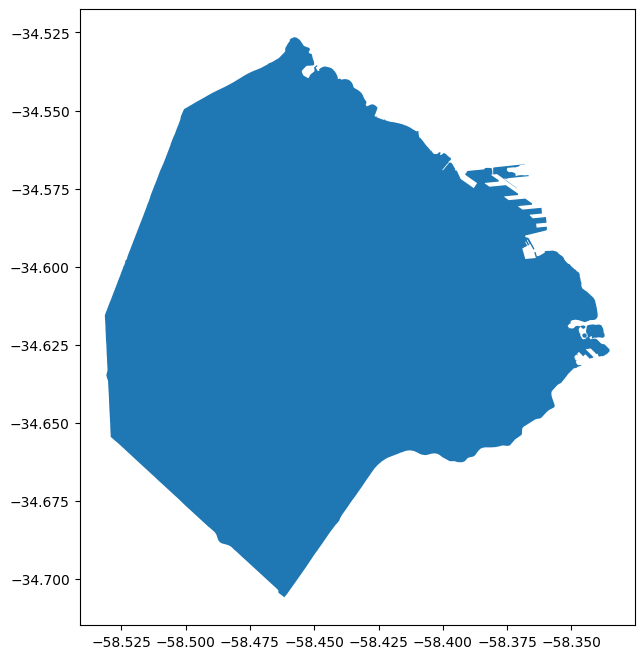

In [53]:
capital.plot()

Luego unimos la base de los teatros con estos límites, y filtramos aquellos que quedaron dentro de la ciudad:

In [54]:
import geopandas as gpd

teatros = gpd.sjoin(teatros, capital)

teatros[teatros.ref=="CABA"]

,tags_left,changeset_left,lon,version_left,id_left,timestamp_left,lat,visible_left,addr:city,addr:country,...,version_right,tags_right,osm_type_right,addr:postcode_right,phone_right,ref,website_right,postal_code,start_date_right,changeset_right
0,"{""addr:suburb"":""Palermo""}",0.0,-58.418983,0,454548621,0,-34.579670,False,Ciudad Autónoma de Buenos Aires,AR,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0
1,"{""check_date"":""2024-06-08"",""wikidata"":""Q382638...",0.0,-58.389812,0,479738122,0,-34.604107,False,None,None,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0
2,"{""official_name"":""Teatro Nacional Cervantes"",""...",0.0,-58.383419,0,669126570,0,-34.598965,False,Ciudad Autónoma de Buenos Aires,AR,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0
3,"{""name:en"":""Teatro Opera"",""wikidata"":""Q937079""...",0.0,-58.378948,0,767725549,0,-34.603706,False,Ciudad Autónoma de Buenos Aires,AR,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0
4,"{""wikidata"":""Q6139910""}",0.0,-58.378632,0,767725550,0,-34.603371,False,None,None,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,None,0.0,-58.387817,0,12041566718,0,-34.604614,False,Ciudad Autónoma de Buenos Aires,None,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0
115,None,0.0,-58.418297,0,12058190017,0,-34.580891,False,None,None,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0
116,None,0.0,-58.396053,0,12331493463,0,-34.605160,False,None,None,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0
117,"{""theatre:type"":""amphi""}",0.0,-58.401501,0,12425016634,0,-34.563938,False,None,None,...,0,"{""ISO3166-2"":""AR-C"",""alt_name"":""Capital Federa...",relation,None,None,CABA,None,None,None,0.0


Con estos 75 teatros estimemos un MMG con 6 componentes:

In [55]:
#Estimamos MMG and obtenemos a que componente pertenece
X = teatros[['lon','lat']].values
MMG_teatros = GaussianMixture(n_components=6, covariance_type='full',random_state=123)
labels = MMG_teatros.fit(X).predict(X)

Asignamos cada teatro a su respectivo cluster:

In [56]:
teatros['cluster']=labels

y grafiquemos los teatros identificando los puntos calientes con distintos colores:

In [57]:
#Mapa base
map = folium.Map(location = [teatros.lat.mean(), teatros.lon.mean()], tiles = "OpenStreetMap", zoom_start = 10)
# Otras opciones de tiles
#Stamen Terrain, Toner, and Watercolor

colour = ['red',
    'orange',
    'green',
    'purple',
    'cadetblue',
    'pink']

def colorCall(val):
  val = int(val)
  return colour[val]

#capa clusters de teatros
for lat, lon, c in zip(teatros['lat'], teatros['lon'], teatros['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        fill_color = colorCall(c),
        fill=True,
        color=colorCall(c),
        fill_opacity=0.7
        ).add_to(map)



#Display el mapa
map

Identificamos entonces 6 puntos calientes donde se ubican los teatros en la ciudad de Buenos Aires. Los más densos están en la 9 de Julio y la calle Corrientes; otro grupo se ubica un poco más al sur por Almagro, y en Palermo. Los grupos restantes parecen detectar ubicaciones más atípicas.

Sin embargo, notemos que especificamos un modelo con 6 componentes. Esto no tiene porque ser necesariamente cierto y los invito a que experimenten y encuentren el número óptimo de componentes.


# Referencias

- Amat Rodrigo, J. Detección de anomalías con Gaussian Minture Modedel (GMM) y python. Disponible en https://www.cienciadedatos.net/documentos/py23-deteccion-anomalias-gmm-python.html. Accedido el 13/04/2022

- Bishop, Christopher M. Pattern Recognition and Machine Learning. (2006). Springer-Verlag Berlin, Heidelberg.

- Deisenroth, M. P., Faisal, A. A., & Ong, C. S. (2020). Mathematics for machine learning. Cambridge University Press.

- Dempster, Arthur P., Laird, Nan M., and Rubin, Donald B. (1977). Maximum Likelihood from Incomplete Data via the EM Algorithm. Journal of the Royal Statistical Society, 39(1), 1–38.

- Murphy, Kevin P.  (2012). Machine Learning: A Probabilistic Perspective. MIT Press, Cambridge, Mass.

- VanderPlas, J. (2016). Python data science handbook: Essential tools for working with data. O'Reilly Media, Inc.